In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [2]:
import tensorflow as tf

path = "./crop_data/image/0000.jpg"
img = tf.image.decode_jpeg(tf.io.read_file(path))
img

<tf.Tensor: shape=(203, 365, 3), dtype=uint8, numpy=
array([[[41, 10,  8],
        [40,  9,  7],
        [40,  9,  7],
        ...,
        [46, 12, 13],
        [47, 15, 16],
        [59, 27, 28]],

       [[40,  9,  7],
        [40,  9,  7],
        [41, 10,  8],
        ...,
        [44, 10, 11],
        [44, 12, 13],
        [56, 24, 25]],

       [[41, 10,  8],
        [41, 10,  8],
        [42, 11,  9],
        ...,
        [43,  9, 10],
        [43, 11, 12],
        [54, 22, 23]],

       ...,

       [[52,  8,  9],
        [53,  9, 10],
        [53,  7,  7],
        ...,
        [59, 10, 13],
        [56, 10, 12],
        [53,  7,  9]],

       [[52,  8,  9],
        [52,  8,  9],
        [53,  7,  7],
        ...,
        [56, 10, 12],
        [56, 10, 12],
        [53,  9, 10]],

       [[51,  7,  8],
        [52,  8,  9],
        [52,  6,  6],
        ...,
        [55,  9, 12],
        [56, 10, 13],
        [53,  9, 10]]], dtype=uint8)>

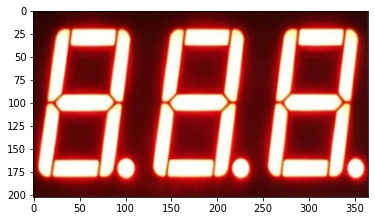

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img)

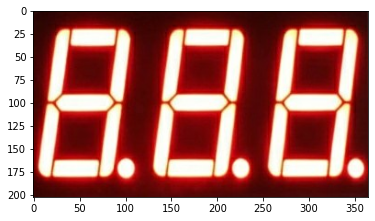

In [4]:
new_img = tf.image.random_jpeg_quality(img, 0, 100)
plt.imshow(new_img)

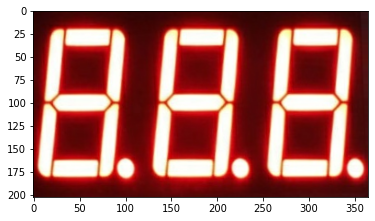

In [5]:
import numpy as np

new_img = tf.keras.preprocessing.image.random_shear(
    img.numpy(), 10, 
    row_axis=0, col_axis=1, channel_axis=2
)
plt.imshow(new_img)

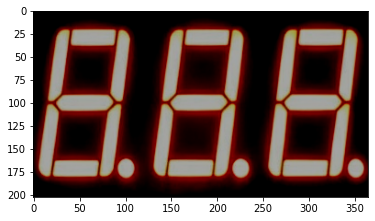

In [6]:
new_img = tf.image.random_brightness(img, 0.4)
plt.imshow(new_img)

### Split data

In [7]:
from glob import glob

img_paths = sorted(glob("./crop_data/image/*.jpg"))
label_paths = sorted(glob("./crop_data/label/*.txt"))

load_img = lambda x:tf.image.decode_jpeg(tf.io.read_file(x))
def load_label(path):
    with open(path, 'r') as f:
        return f.read()

images = list(map(load_img, img_paths))
labels = list(map(load_label, label_paths))
char_list = sorted(set(''.join(labels)))

In [8]:
from sklearn.model_selection import train_test_split

idxs = range(len(images))
train_idxs, valid_idxs = train_test_split(idxs, test_size=0.1, random_state=42)

### Mapping token

In [9]:
from tensorflow.keras import layers

char_to_num = layers.StringLookup(vocabulary=char_list, mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

### Hint max width, length

In [10]:
IMG_HEIGHT = 64

max_width = 0
for img in images:
    h, w = img.shape[:2]
    target_h, target_w = IMG_HEIGHT, int(w/h*IMG_HEIGHT)
    if max_width < target_w:
        max_width = target_w
print(max_width)

max_length = max([len(label) for label in labels])
print(max_length)

384
16


### Set dataset

In [11]:
IMG_HEIGHT = 64
MAX_WIDTH = 512
MAX_LENGTH = 20
BATCH_SIZE = 64

def data_generator(indexes, mutation=True):
    for i in indexes:
        img = images[i]
        label = labels[i]
        # mutation
        if mutation:
            img = tf.image.random_jpeg_quality(img, 0, 100)
            img = tf.keras.preprocessing.image.random_shear(img.numpy(), 10, 
                                                            row_axis=0, col_axis=1, channel_axis=2)
            img = tf.image.random_brightness(img, 0.4)
        # resize
        img = tf.image.convert_image_dtype(img, tf.float32)
        h, w = tf.shape(img)[0], tf.shape(img)[1]
        target_h, target_w = IMG_HEIGHT, int(w/h*IMG_HEIGHT)
        img = tf.image.resize(img, [target_h, target_w])
        # pad
        img = tf.image.pad_to_bounding_box(img, 0, 0, IMG_HEIGHT, MAX_WIDTH)
        # transpose
        img = tf.transpose(img, perm=[1, 0, 2])
        
        # tokenize label 
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        label = tf.pad(label, [[0,MAX_LENGTH-tf.size(label)],], mode="CONSTANT")
        
        yield img, label

train_ds = tf.data.Dataset.from_generator(data_generator, 
                                          output_types=(tf.float32, tf.int64),
                                          output_shapes=([MAX_WIDTH,IMG_HEIGHT,3], [MAX_LENGTH]), 
                                          args=(train_idxs,))
valid_ds = tf.data.Dataset.from_generator(lambda x:data_generator(x, False), 
                                          output_types=(tf.float32, tf.int64),
                                          output_shapes=([MAX_WIDTH,IMG_HEIGHT,3], [MAX_LENGTH]), 
                                          args=(train_idxs,))
train_ds = train_ds.shuffle(256).batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(256).batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.AUTOTUNE)

### Define loss

In [12]:
import tensorflow as tf

loss_fn = tf.keras.backend.ctc_batch_cost

def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64") # 16
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # 50
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64") # 5

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = loss_fn(y_true, y_pred, input_length, label_length)
    return loss

### Define model

In [ ]:
def build_model(input_shape=(MAX_WIDTH, IMG_HEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)
    # backbone = tf.keras.applications.MobileNetV3Small(input_shape=(MAX_WIDTH,IMG_HEIGHT,3), 
    #                                                   include_top=False).
    # x = back
    
        
    arg_dic = {"activation":"swish", "padding":"same", "kernel_initializer":"he_normal"}
    x = layers.Conv2D(32, 3, **arg_dic)(input_img)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, **arg_dic)(x)
    x = layers.MaxPooling2D()(x)

    arg_dic["activation"] = None
    x = layers.Conv2D(64, 3, **arg_dic)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = layers.Dropout(0.15)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Reshape(target_shape=(MAX_WIDTH // 8, -1), name="Reshape")(x)

    # x = layers.Conv1D(128, 1, **arg_dic)(x) 
    x = layers.Conv1D(256, 3, **arg_dic)(x) 
    x = layers.Conv1D(128, 1, activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25))(x)

#     # Output layer
    # x = layers.Dense(len(char_to_num.get_vocabulary()) + 1,
    #                  activation="softmax")(x)
    x = layers.Conv1D(len(char_to_num.get_vocabulary()) + 1, 1, activation='softmax')(x)

    # Define the model
    model = tf.keras.models.Model(inputs=input_img, outputs=x, name="ocr_model_v1")
    return model

In [74]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 512, 64, 3)]      0         
                                                                 
 conv2d_54 (Conv2D)          (None, 512, 64, 32)       896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 256, 32, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 256, 32, 64)       18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 128, 16, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 128, 16, 64)      

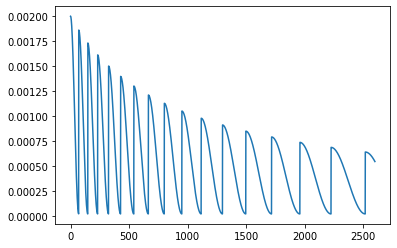

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt

lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
                initial_learning_rate = 2e-3, # 최초의 학습률
                first_decay_steps = 70, # (첫 주기의 감쇄가 진행되는 총 스텝 수) 최초의 주기 길이
                t_mul = 1.1, # 주기 T를 늘려갈 비율 (100step -> 200step -> 400step)
                m_mul = 0.93, # 최초 학습률로 설정한 값에 매 주기마다 곱해줄 값, 다음 주기부터 학습률이 작아진다.
                alpha = 1e-2, # 학습률의 하한, 최소는 initial_learning_rate * alpha가 된다.
                name = None,
            )


x = range(2600)
y = lr_decayed_fn(x)
plt.plot(x, y)
plt.show()

In [79]:
model = build_model()

optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)
model.compile(optimizer=optimizer, loss=CTC_loss)

early_stopping_patience = 20
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)


n_epochs = 300
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
#                                                  patience=10, min_lr=1e-5)

# def scheduler(epoch, lr):
#     if epoch < 30: return lr
#     else: return lr * tf.math.exp(-0.1)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_ds, epochs=n_epochs, validation_data=valid_ds, 
                    callbacks=[early_stopping,])

Epoch 1/300
26/26 [==============================] - 49s 1s/step - loss: 29.5729 - val_loss: 14.4300
Epoch 2/300
26/26 [==============================] - 37s 1s/step - loss: 14.0085 - val_loss: 13.5631
Epoch 3/300
26/26 [==============================] - 37s 1s/step - loss: 13.6542 - val_loss: 13.3300
Epoch 4/300
26/26 [==============================] - 36s 1s/step - loss: 13.3376 - val_loss: 13.1157
Epoch 5/300
26/26 [==============================] - 37s 1s/step - loss: 12.9685 - val_loss: 12.8021
Epoch 6/300
26/26 [==============================] - 37s 1s/step - loss: 12.8808 - val_loss: 12.8283
Epoch 7/300
26/26 [==============================] - 37s 1s/step - loss: 12.7664 - val_loss: 12.5463
Epoch 8/300
26/26 [==============================] - 37s 1s/step - loss: 12.6186 - val_loss: 12.4517
Epoch 9/300
26/26 [==============================] - 37s 1s/step - loss: 12.5211 - val_loss: 13.4430
Epoch 10/300
26/26 [==============================] - 37s 1s/step - loss: 14.1169 - val_los

### Save Model

In [80]:
model.save('7seg_ocr.h5')

### Show history

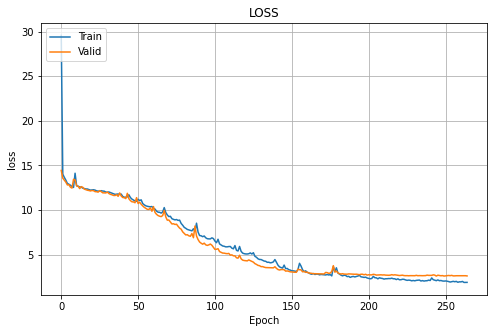

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.grid(True)
plt.savefig('./temp/epoch_loss.jpg')
plt.show()

### Visualize Result

In [82]:
SORTED_CHARS = sorted([':', '.', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
IMG_HEIGHT = 64
MAX_WIDTH = 512
MAX_LENGTH = 20
char_to_num = tf.keras.layers.StringLookup(vocabulary=SORTED_CHARS, mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

class CTCDecodeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CTCDecodeLayer, self).__init__(**kwargs)
        self.decoder = tf.keras.backend.ctc_decode
    
    def __call__(self, y_pred):
        shape = tf.shape(y_pred)
        input_len = tf.ones(shape[0]) * tf.cast(shape[1], dtype=tf.float32)
        results = self.decoder(y_pred, input_length=input_len, greedy=True)[0][0][:,:MAX_LENGTH]
        results = tf.strings.reduce_join(num_to_char(results), axis=1)

        return results

In [86]:
def get_inference_model(model_path, input_shape=(MAX_WIDTH, IMG_HEIGHT, 3)):
    image = tf.keras.layers.Input(shape=input_shape, name='Image')
    model = tf.keras.models.load_model(model_path, compile=False)
    y_pred = model(image, training=False)
    decoded = CTCDecodeLayer(name='CTC_Decode')(y_pred)
    inference_model = tf.keras.Model(inputs=image, outputs=decoded)
    return inference_model

inference_model = get_inference_model('7seg_ocr.h5')

2/2 [==============================] - 0s 13ms/step
0.11856722831726074


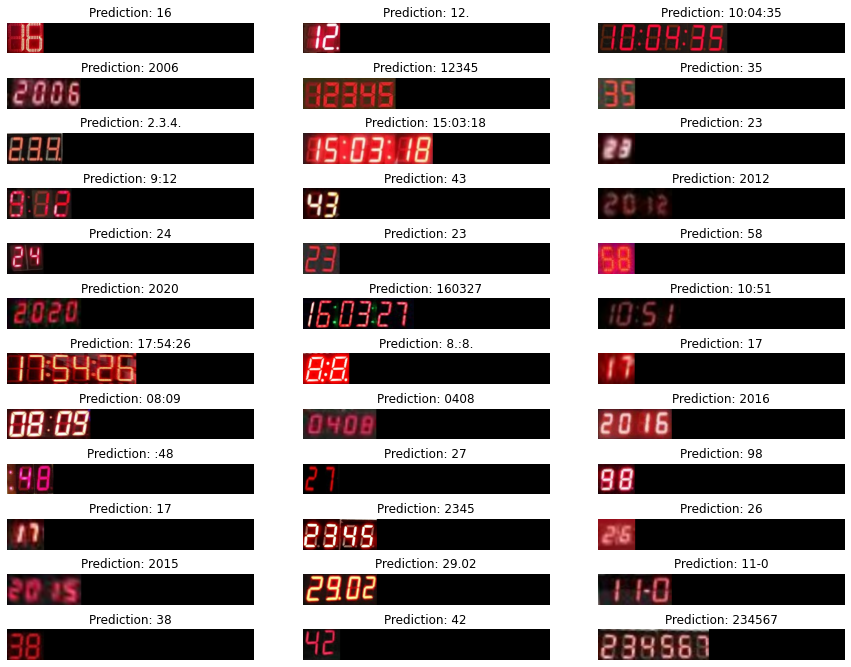

In [102]:
import matplotlib.pyplot as plt
import time

for batch in valid_ds.skip(10).take(1):
    batch_images, batch_labels = batch

    start = time.time()
    batch_preds = inference_model.predict(batch_images[:36])
    batch_labels = tf.strings.reduce_join(num_to_char(batch_labels), axis=1).numpy()
    end = time.time()
    print(end - start)

    batch_preds = list(map(lambda x:x.decode('utf-8'), batch_preds))
    batch_labels = list(map(lambda x:x.decode('utf-8'), batch_labels))

    _, ax = plt.subplots(12, 3, figsize=(15, 12))
    for i in range(len(batch_preds)):
        img = (batch_images[i, :, :, :3] * 255).numpy().astype(np.uint8)
        # img = img.T
        img = np.transpose(img, axes=[1,0,2])
        title = f"Prediction: {batch_preds[i]}"
        ax[i // 3, i % 3].imshow(img, cmap="gray")
        ax[i // 3, i % 3].set_title(title.strip('[UNK]'))
        ax[i // 3, i % 3].axis("off")
        
plt.savefig('./temp/savef_plt.jpg')
plt.show()